In [1]:
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from shapely.geometry import box, mapping
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from PIL import Image

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config("base")

17-Dec-23 00:43:34 - INFO - Starting 'load_config'.
17-Dec-23 00:43:34 - INFO - Finished 'load_config' in 0.0212 secs.


In [3]:
def plot_raster(raster):
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap='gray')
    plt.colorbar()
    plt.show()


def clip_gdf(gdf, bounds):
    clipped_gdf = gdf[
        (gdf.geometry.x > bounds.left) & 
        (gdf.geometry.x < bounds.right) &
        (gdf.geometry.y > bounds.bottom) &
        (gdf.geometry.y < bounds.top)
    ]
    logger.info(f"Original gdf: {gdf.shape}")
    logger.info(f"Clipped gdf: {clipped_gdf.shape}")
    logger.info(f"Species split: {clipped_gdf.Species.value_counts()}")
    return clipped_gdf


def process_shp(clipped_gdf, buffer=10):
    gdf_copy = clipped_gdf.copy()
    gdf_copy['buffer'] = gdf_copy.buffer(buffer)
    return gdf_copy


def crop_buffer(raster, polygon, path_pri, pid, raster_type, label, rgb=False, path_int_cr_imgs=None):
    geojson_polygon = mapping(polygon)
    out_image, out_transform = mask(raster, [geojson_polygon], crop=True)
    out_meta = raster.meta.copy()
    out_meta.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    return out_image, out_meta



def equalize_histogram(image: np.ndarray) -> np.ndarray:
    """
    Equalizes the histogram of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The image with equalized histogram.
    """
    # Normalize the image to 0-1 range
    image_norm = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Convert the normalized image to 8-bit
    image_8bit = np.uint8(image_norm * 255)

    # Flatten the image into 1D array
    image_flattened = image_8bit.flatten()

    # Perform histogram equalization
    equalized_image = cv2.equalizeHist(image_flattened)

    # Reshape the equalized image back to the original shape
    equalized_image = equalized_image.reshape(image.shape)

    return equalized_image


def plot_crop(dsm_crop, dtm_crop, ndsm):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    rasterio.plot.show(dsm_crop, ax=ax1, cmap='gray')
    rasterio.plot.show(dtm_crop, ax=ax2, cmap='gray')
    rasterio.plot.show(ndsm, ax=ax3, cmap='gray')
    plt.show()


def crop_to_smaller(image1: np.ndarray, image2: np.ndarray) -> np.ndarray:
    """
    Crops the larger image to match the size of the smaller one.

    Parameters:
    - image1 (numpy.ndarray): The first image.
    - image2 (numpy.ndarray): The second image.

    Returns:
    - numpy.ndarray: The cropped image.
    """
    # Determine the smaller shape
    smaller_shape = min(image1.shape, image2.shape)

    # Crop image1 if it is larger
    if image1.shape != smaller_shape:
        if image1.ndim == 3:
            image1 = image1[:, :smaller_shape[1], :smaller_shape[2]]
        elif image1.ndim == 2:
            image1 = image1[:smaller_shape[0], :smaller_shape[1]]

    # Crop image2 if it is larger
    if image2.shape != smaller_shape:
        if image2.ndim == 3:
            image2 = image2[:, :smaller_shape[1], :smaller_shape[2]]
        elif image2.ndim == 2:
            image2 = image2[:smaller_shape[0], :smaller_shape[1]]

    return image1, image2


In [4]:
dsm = utils.load_raster(f"{conf.data.path_base_dsm}{conf.data.fn_dsm}")
dtm = utils.load_raster(f"{conf.data.path_base_dtm}{conf.data.fn_dtm}")
gdf = gpd.read_file(f"{conf.data.path_base_points}{conf.data.fn_shp_combined}")
target_bounds = dsm.bounds
clipped_gdf = clip_gdf(gdf, target_bounds)

dsm_arr = dsm.read(1)
dtm_arr = dtm.read(1)

17-Dec-23 00:43:34 - INFO - Loaded image: ../data/01_base/dsm_7cm_resampled/dsm_aoi_1.tif
17-Dec-23 00:43:34 - INFO - Image channels: 1
17-Dec-23 00:43:34 - INFO - Image size: 22377x23466
17-Dec-23 00:43:34 - INFO - Image crs: EPSG:32736
17-Dec-23 00:43:34 - INFO - Image bounds: BoundingBox(left=362292.7863346958, bottom=7356585.920366846, right=363843.73620469583, top=7358212.348826846)
17-Dec-23 00:43:34 - INFO - Image transform: | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.35|
| 0.00, 0.00, 1.00|
17-Dec-23 00:43:34 - INFO - Loaded image: ../data/01_base/dtm_7cm_resampled/dtm_aoi_1.tif
17-Dec-23 00:43:34 - INFO - Image channels: 1
17-Dec-23 00:43:34 - INFO - Image size: 22376x23464
17-Dec-23 00:43:34 - INFO - Image crs: EPSG:32736
17-Dec-23 00:43:34 - INFO - Image bounds: BoundingBox(left=362292.7863346958, bottom=7356585.965130846, right=363843.7563986958, top=7358212.348826846)
17-Dec-23 00:43:34 - INFO - Image transform: | 0.07, 0.00, 362292.79|
| 0.00,-0.07, 7358212.35|
| 0.00,

17-Dec-23 00:43:34 - INFO - Original gdf: (306, 3)
17-Dec-23 00:43:34 - INFO - Clipped gdf: (44, 3)
17-Dec-23 00:43:34 - INFO - Species split: Species
Xanthium    17
Datura      14
Other       13
Name: count, dtype: int64


In [5]:
dsm_min_value = np.min(dsm_arr)
dsm_max_value = np.max(dsm_arr)
dsm_mean_value = np.mean(dsm_arr)
dtm_min_value = np.min(dtm_arr)
dtm_max_value = np.max(dtm_arr)
dtm_mean_value = np.mean(dtm_arr)
dsm_min_value, dsm_max_value, dsm_mean_value, dtm_min_value, dtm_max_value, dtm_mean_value

(0.0, 228.64696, 100.11342, 0.0, 222.59662, 99.83103)

In [10]:
gdf_copy = process_shp(clipped_gdf, buffer=10)
gdf_copy = gdf_copy[:2]

In [11]:
for _, row in gdf_copy.iterrows():
    dsm_crop, out_meta = crop_buffer(dsm, row.buffer, conf.data.path_int_cr_tif, row.pid, 'dsm', row.Species)
    dtm_crop, out_meta = crop_buffer(dtm, row.buffer, conf.data.path_int_cr_tif, row.pid, 'dtm', row.Species)

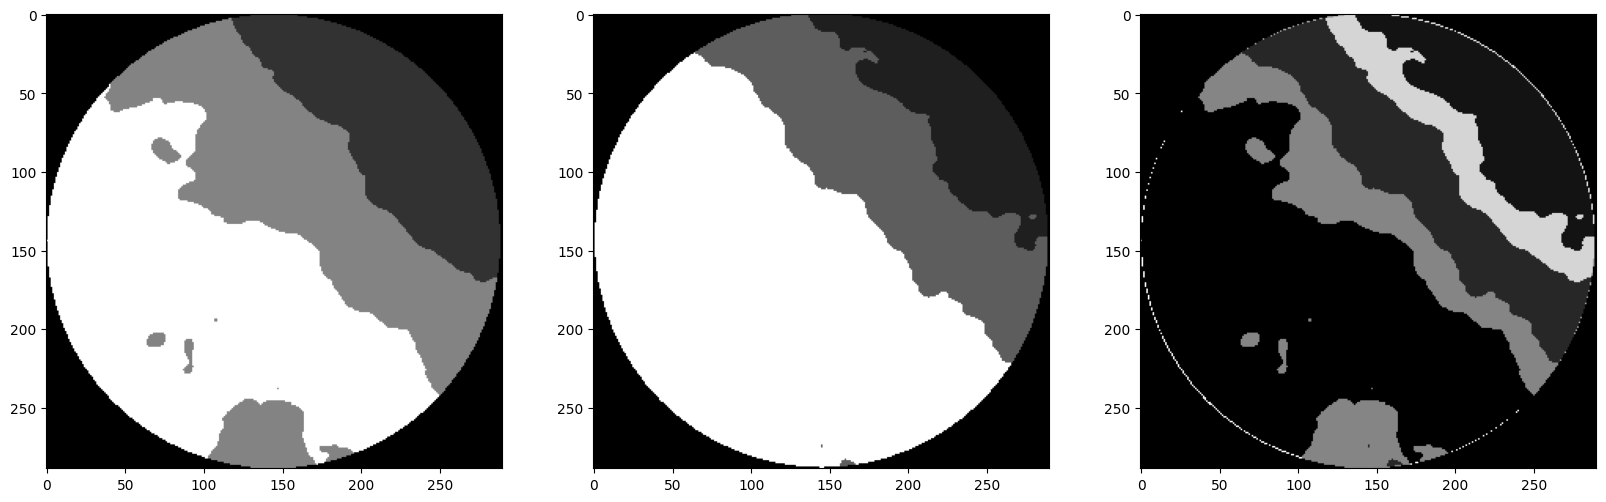

In [13]:
# Assuming 'dsm' is your DSM data
equalized_dsm = equalize_histogram(dsm_crop[0])
eqalized_dtm = equalize_histogram(dtm_crop[0])
equalized_dsm, eqalized_dtm = crop_to_smaller(equalized_dsm, eqalized_dtm)
ndsm = equalized_dsm - eqalized_dtm
plot_crop(equalized_dsm, eqalized_dtm, ndsm)

In [ ]:
# plot_raster(out_image)

In [ ]:
# plot_raster(dsm_arr)

In [ ]:
# plot_raster(dtm_arr)